# XGBoost
In this notebook the XGBoost model will be implemented. We will use historical energy consumption data and meteorological data to make a prediction on future consumption values.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

seed=99
random.seed(seed)
np.random.seed(seed)

In [35]:
morocco = pd.read_csv("../data/morocco.csv")

## Preprocessing
Before starting the regression analysis and prediction modeling we will have to prepare the data, clean it and process it.

In [49]:
morocco.dtypes

Temperature              float64
Humidity                 float64
Wind Speed               float64
general diffuse flows    float64
diffuse flows            float64
Consumption              float64
year                       int32
month                      int32
day                        int32
hour                       int32
dtype: object

In [37]:
morocco['Consumption'] = morocco['Zone 1 Power Consumption'] + morocco['Zone 2  Power Consumption'] + morocco['Zone 3  Power Consumption']
morocco = morocco.drop(['Zone 1 Power Consumption','Zone 2  Power Consumption', 'Zone 3  Power Consumption'], axis=1)

In [38]:
morocco['DateTime'] = pd.to_datetime(morocco['DateTime'], format='%m/%d/%Y %H:%M')
#morocco.set_index('DateTime', inplace=True)

In [48]:
morocco['year'] = morocco['DateTime'].dt.year
morocco['month'] = morocco['DateTime'].dt.month
morocco['day'] = morocco['DateTime'].dt.day
morocco['hour'] = morocco['DateTime'].dt.hour

morocco = morocco.drop(columns=['DateTime'])

## Split data into training and test sets

The Morocco dataset contains one year of data of 10 min granularity. In order to respect the temporal order of observations we'll split on a given timestep and use the data before the respective timestamp as training data and the data after will be used for testing.

In [54]:
split_date = pd.Timestamp('2017-12-01')

train = morocco[(morocco['month'] < 12)]
test = morocco[(morocco['month'] >= 12)]

X_train = train.drop(columns=['Consumption'])
y_train = train['Consumption']

X_test = test.drop(columns=['Consumption'])
y_test = test['Consumption']

## Regression analysis

In [55]:
X_train.dtypes

Temperature              float64
Humidity                 float64
Wind Speed               float64
general diffuse flows    float64
diffuse flows            float64
year                       int32
month                      int32
day                        int32
hour                       int32
dtype: object

In [56]:
print('Equal length:',X_train.shape[0] == y_train.shape[0])

Equal length: True


In [57]:
model = xgb.XGBRegressor(objective ='reg:squarederror', random_state=seed)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=99, ...)

In [58]:
y_pred = model.predict(X_test)

## Evaluate model accuracy

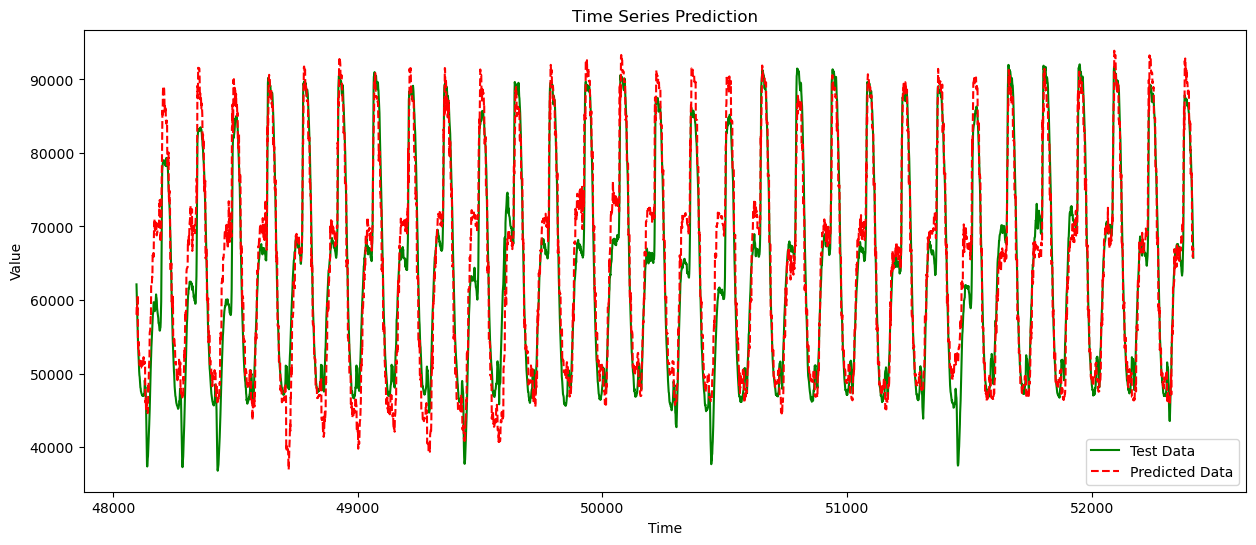

In [73]:
plt.figure(figsize=(15, 6))
#plt.plot(y_train.index[34000:], y_train[34000:], label='Training Data', color='blue')
plt.plot(y_test.index, y_test, label='Test Data', color='green')

# Overlay y_pred
plt.plot(y_test.index, y_pred, label='Predicted Data', linestyle='--', color='red')

plt.title('Time Series Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [59]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# NRMSE

r2 = r2_score(y_test, y_pred)
print(f"R-squared (R^2): {r2}")

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Root Mean Squared Error (RMSE): 4433.655123290253
R-squared (R^2): 0.9038071878299572
Mean Absolute Percentage Error (MAPE): 5.778441540293818%


## Hyperparameter tuning
learning_rate, max_depth, n_estimators, and subsample